## Detectron2 Training

**Set the following variables, and run all.**

The notebook reports COCO eval metrics and visualizations at the end.

`img_dir`: location of all images (both training and test)

`train_json`: COCO annotation file consisting of training set annotations 

`test_json`: COCO annotation file consisting of test / validation set annotations

`dataset_name`: a name for the dataset, for detectron2 bookkeeping

In [38]:
coco_yaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
lvis_yaml = "LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
lvis_yaml2 = "LVIS-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml"
pano_yaml = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"

img_dir_test = '/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data/frl_apartment_1/rgb'
# test_json = 'active_vision/frlapt1_10n.json'
test_jsons = ['active_vision/frlapt1_20n0.json', 'active_vision/frlapt1_20n1.json', 'active_vision/frlapt1_20n2.json']

# test_json = 'active_vision/sanity_default_apt0_segn.json' 
# img_dir_test = '/checkpoint/apratik/finals/default/apartment_0/rgb'

img_dir_train = '/checkpoint/apratik/finals/default/apartment_0/rgb'

# img_dir = '/home/locobotm/AVD/habitat_data_with_seg/rgb/'
# train_json = '/home/locobotm/AVD/habitat_data_with_seg/train.json'

# sanity checking 
# train_jsons = [
#     'active_vision/sanity_default_apt0_1n.json',
#     'active_vision/sanity_default_apt0_10n.json',
#     'active_vision/sanity_default_apt0_20n.json',
#     'active_vision/sanity_default_apt0_30n.json',
#     'active_vision/sanity_default_apt0_40n.json',
#     'active_vision/sanity_default_apt0_50n.json',
#     'active_vision/sanity_default_apt0_60n.json',
#     'active_vision/sanity_default_apt0_70n.json',
#     'active_vision/sanity_default_apt0_80n.json',
# ]

# Table 2 - prop fixed, label prop, different GT frames, default heu
train_jsons = [
    'active_vision/default_apt0_gt50p2fix_corln.json',
    'active_vision/default_apt0_gt100p2fix_corln.json',
    'active_vision/default_apt0_gt150p2fix_corln.json',
    'active_vision/default_apt0_gt200p2fix_corln.json',
    'active_vision/default_apt0_gt250p2fix_corln.json',
]

# Table 2 - prop fixed, no label prop, different GT frames
# train_jsons = [
#     'active_vision/base_straightline_apt0_gt50p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt100p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt150p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt200p2fix_corln.json',
#     'active_vision/base_straightline_apt0_gt250p2fix_corln.json',
# ]

# Table 2 - prop fixed, label prop, different GT frames
# train_jsons = [
#     'active_vision/straightline_apt0_gt50p2fix_corln.json',
#     'active_vision/straightline_apt0_gt100p2fix_corln.json',
#     'active_vision/straightline_apt0_gt150p2fix_corln.json',
#     'active_vision/straightline_apt0_gt200p2fix_corln.json',
#     'active_vision/straightline_apt0_gt250p2fix_corln.json',
# ]

# Table 1 - gt fixed, different label prop lengths
# train_jsons = [
#     'active_vision/straightline_apt0_gt100p1_corln.json',
#     'active_vision/straightline_apt0_gt100p2_corln.json',
#     'active_vision/straightline_apt0_gt100p4_corln.json',
#     'active_vision/straightline_apt0_gt100p6_corln.json',
# ]

# train_jsons = [
#     'active_vision/default_apt0_gt100p1_corln.json',
#     'active_vision/default_apt0_gt100p2_corln.json',
#     'active_vision/default_apt0_gt100p4_corln.json',
#     'active_vision/default_apt0_gt100p6_corln.json',
# ]
    

dataset_name = 'habitat_1'

In [39]:
import torchvision

# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import random
import os
import numpy as np
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, build_detection_train_loader
import detectron2.data.transforms as T
import shutil

import random
import torch 
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image

pd.set_option('max_colwidth', 300)

import glob
from IPython.core.display import display, HTML

pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))

os.environ['TENSORBOARD_BINARY'] = '/private/home/apratik/.conda/envs/locobot_env/bin/tensorboard'

## Detectron2 Setup

from copy_paste import CopyPaste
import albumentations as A

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, output_dir=output_folder)
    
    @classmethod
    def build_train_loader(cls, cfg):
        transform = T.AugmentationList([
              CopyPaste(blend=True, sigma=1, pct_objects_paste=0.5, p=1)
            ], bbox_params=A.BboxParams(format="coco")
        )
        mapper = DatasetMapper(cfg, is_train=True, augmentations=transform)
        return build_detection_train_loader(cfg, mapper=mapper)

class COCOTrain:
    def __init__(self, lr, w, maxiters):
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file(coco_yaml))
        self.cfg.SOLVER.BASE_LR = lr  # pick a good LR
        self.cfg.SOLVER.MAX_ITER = maxiters
        self.cfg.SOLVER.WARMUP_ITERS = w
        
    def reset(self, train_json, test_json, img_dir_train, img_dir_test, dataset_name):
        DatasetCatalog.clear()
        MetadataCatalog.clear()
        self.train_data = dataset_name +  "_train"
        self.train_json = train_json
        register_coco_instances(self.train_data, {}, train_json, img_dir_train)
        self.results = {
            "bbox": {
                "AP50": []
            },
            "segm": {
                "AP50": []
            }
        }
    
    def vis(self):
        dataset_dicts = DatasetCatalog.get(self.train_data)
        for d in random.sample(dataset_dicts, 2):
            img = cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(self.train_data), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            plt.figure(figsize=(12,8))
            plt.imshow(img)
            plt.show()
            
    def train(self):
        cfg = self.cfg
        print(f'SOLVER PARAMS {cfg.SOLVER.MAX_ITER, cfg.SOLVER.WARMUP_ITERS, cfg.SOLVER.BASE_LR}')
        cfg.DATASETS.TRAIN = (self.train_data,)
        cfg.DATASETS.TEST = ()
        cfg.DATALOADER.NUM_WORKERS = 2
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(coco_yaml)  # Let training initialize from model zoo
        cfg.SOLVER.IMS_PER_BATCH = 2
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(self.train_data).get("thing_classes"))  
        cfg.OUTPUT_DIR = os.path.join('output', str(cfg.SOLVER.MAX_ITER), x.split('.')[0][len('active_vision/'):])
        print(f"recreating {cfg.OUTPUT_DIR}")
        if os.path.isdir(cfg.OUTPUT_DIR):
            shutil.rmtree(cfg.OUTPUT_DIR)
        print(cfg.OUTPUT_DIR)
        os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        self.trainer = DefaultTrainer(cfg) 
        self.trainer.resume_or_load(resume=False)
        self.trainer.train()

    def run_eval(self, dataset_name, test_json, img_dir_test):
        self.val_data = dataset_name + "_val"
        self.test_json = test_json
        self.cfg.DATASETS.TEST = (self.val_data,)
        register_coco_instances(self.val_data, {}, test_json, img_dir_test)
        
        self.evaluator = COCOEvaluator(self.val_data, ("bbox", "segm"), False, output_dir=self.cfg.OUTPUT_DIR)
        self.val_loader = build_detection_test_loader(self.cfg, self.val_data)
        results = inference_on_dataset(self.trainer.model, self.val_loader, self.evaluator)
        self.results['bbox']['AP50'].append(results['bbox']['AP50'])
        self.results['segm']['AP50'].append(results['segm']['AP50'])
        # another equivalent way to evaluate the model is to use `trainer.test`
        with open('nway_eval.txt', 'a') as f:
            f.write(f"\ntrain {self.train_json}, test {self.test_json}")
            f.write(f'\nmaxiter {self.cfg.SOLVER.MAX_ITER}, \
                    lr {self.cfg.SOLVER.BASE_LR}, \
                    warmup_iters {self.cfg.SOLVER.WARMUP_ITERS}')
            f.write(json.dumps(results))
            f.write("##########\n\n")
        
    def run_train(self, train_json, test_json, img_dir_train, img_dir_test, dataset_name):
        self.reset(train_json, test_json, img_dir_train, img_dir_test, dataset_name)
        self.vis()
        self.train()

dataset_name default_apt0_gt50p2fix_corln
829 829
[06/21 21:30:19 d2.data.datasets.coco]: Loaded 200 images in COCO format from active_vision/default_apt0_gt50p2fix_corln.json


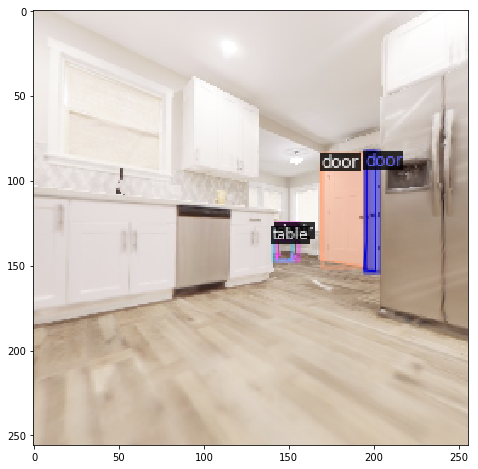

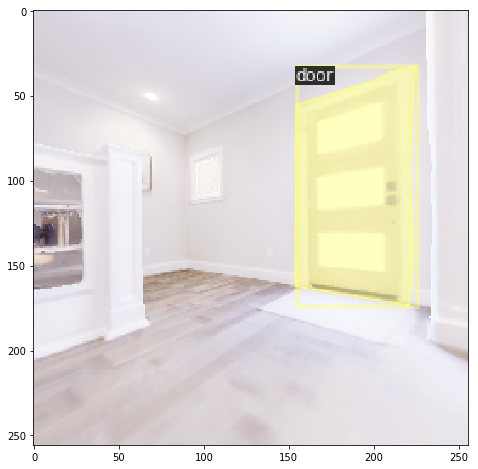

SOLVER PARAMS (500, 100, 0.001)
recreating output/500/default_apt0_gt50p2fix_corln
output/500/default_apt0_gt50p2fix_corln
[06/21 21:30:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/21 21:30:21 d2.engine.train_loop]: Starting training from iteration 0
[06/21 21:30:26 d2.utils.events]:  eta: 0:01:52  iter: 19  total_loss: 3.495  loss_cls: 1.581  loss_box_reg: 0.7713  loss_mask: 0.6887  loss_rpn_cls: 0.2046  loss_rpn_loc: 0.1597  time: 0.2359  data_time: 0.0105  lr: 0.00019081  max_mem: 3522M
[06/21 21:30:30 d2.utils.events]:  eta: 0:01:47  iter: 39  total_loss: 2.218  loss_cls: 0.607  loss_box_reg: 0.6536  loss_mask: 0.6396  loss_rpn_cls: 0.1162  loss_rpn_loc: 0.09117  time: 0.2334  data_time: 0.0038  lr: 0.00039061  max_mem: 3522M
[06/21 21:30:35 d2.utils.events]:  eta: 0:01:42  iter: 59  total_loss: 2.184  loss_cls: 0.5989  loss_box_reg: 0.8259  loss_mask: 0.5363  loss_rpn_cls: 0.08179  loss_rpn_loc: 0.0611  time: 0.2351  data_time: 0.0040  lr: 0.00059041  max_mem: 3522M
[06/21 21:30:40 d2.utils.events]:  eta: 0:01:37  iter: 79  total_loss: 1.819  loss_cls: 0.3988  loss_box_reg: 0.7287  loss_mask: 0.4907  loss_rpn_cls: 0.08306  loss_rpn_loc: 0.1428  time: 0.2

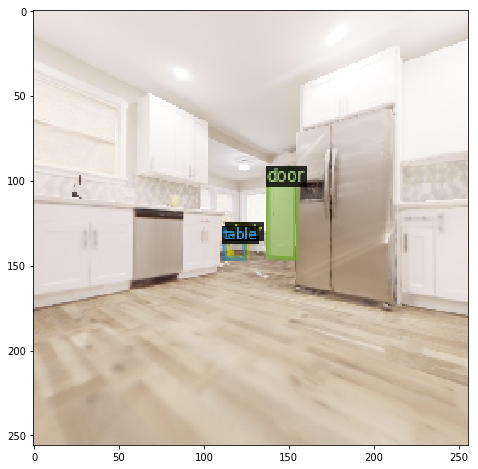

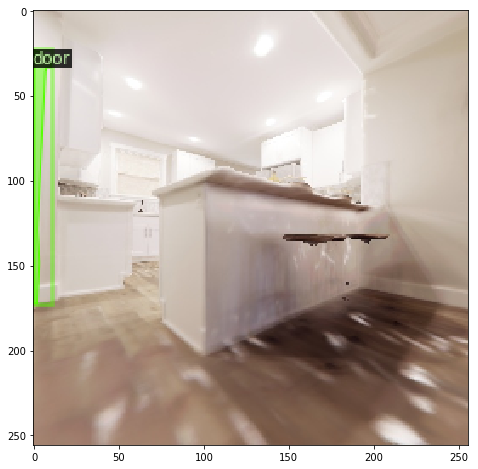

SOLVER PARAMS (500, 100, 0.001)
recreating output/500/default_apt0_gt50p2fix_corln
output/500/default_apt0_gt50p2fix_corln
[06/21 21:34:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/21 21:34:14 d2.engine.train_loop]: Starting training from iteration 0
[06/21 21:34:19 d2.utils.events]:  eta: 0:01:52  iter: 19  total_loss: 3.526  loss_cls: 1.592  loss_box_reg: 0.8703  loss_mask: 0.6897  loss_rpn_cls: 0.3331  loss_rpn_loc: 0.1628  time: 0.2357  data_time: 0.0123  lr: 0.00019081  max_mem: 3522M
[06/21 21:34:24 d2.utils.events]:  eta: 0:01:46  iter: 39  total_loss: 2.313  loss_cls: 0.7104  loss_box_reg: 0.7655  loss_mask: 0.6298  loss_rpn_cls: 0.06861  loss_rpn_loc: 0.1357  time: 0.2323  data_time: 0.0039  lr: 0.00039061  max_mem: 3522M
[06/21 21:34:29 d2.utils.events]:  eta: 0:01:43  iter: 59  total_loss: 2.216  loss_cls: 0.6071  loss_box_reg: 0.8383  loss_mask: 0.5704  loss_rpn_cls: 0.07469  loss_rpn_loc: 0.08926  time: 0.2363  data_time: 0.0040  lr: 0.00059041  max_mem: 3522M
[06/21 21:34:34 d2.utils.events]:  eta: 0:01:38  iter: 79  total_loss: 1.787  loss_cls: 0.4447  loss_box_reg: 0.7542  loss_mask: 0.475  loss_rpn_cls: 0.04389  loss_rpn_loc: 0.04754  time: 0

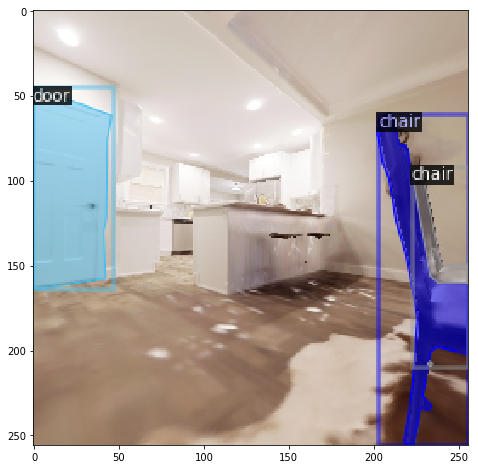

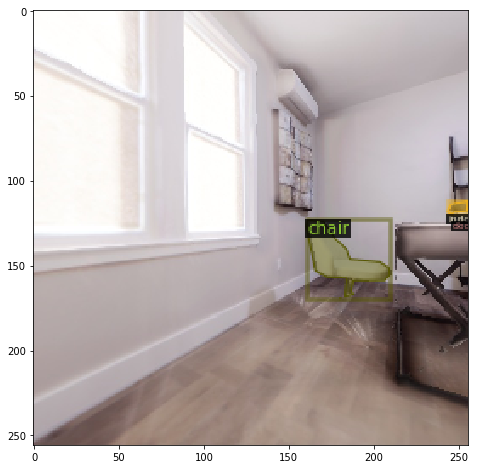

SOLVER PARAMS (500, 100, 0.001)
recreating output/500/default_apt0_gt50p2fix_corln
output/500/default_apt0_gt50p2fix_corln
[06/21 21:37:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/21 21:37:50 d2.engine.train_loop]: Starting training from iteration 0
[06/21 21:37:55 d2.utils.events]:  eta: 0:01:50  iter: 19  total_loss: 3.376  loss_cls: 1.541  loss_box_reg: 0.6675  loss_mask: 0.6878  loss_rpn_cls: 0.3888  loss_rpn_loc: 0.1386  time: 0.2266  data_time: 0.0115  lr: 0.00019081  max_mem: 3522M
[06/21 21:38:00 d2.utils.events]:  eta: 0:01:47  iter: 39  total_loss: 2.624  loss_cls: 0.7897  loss_box_reg: 0.7944  loss_mask: 0.6312  loss_rpn_cls: 0.08637  loss_rpn_loc: 0.1334  time: 0.2336  data_time: 0.0039  lr: 0.00039061  max_mem: 3522M
[06/21 21:38:05 d2.utils.events]:  eta: 0:01:43  iter: 59  total_loss: 2.086  loss_cls: 0.541  loss_box_reg: 0.8416  loss_mask: 0.5587  loss_rpn_cls: 0.05718  loss_rpn_loc: 0.09447  time: 0.2358  data_time: 0.0039  lr: 0.00059041  max_mem: 3522M
[06/21 21:38:09 d2.utils.events]:  eta: 0:01:38  iter: 79  total_loss: 1.86  loss_cls: 0.4544  loss_box_reg: 0.7437  loss_mask: 0.4786  loss_rpn_cls: 0.06744  loss_rpn_loc: 0.1111  time: 0.2

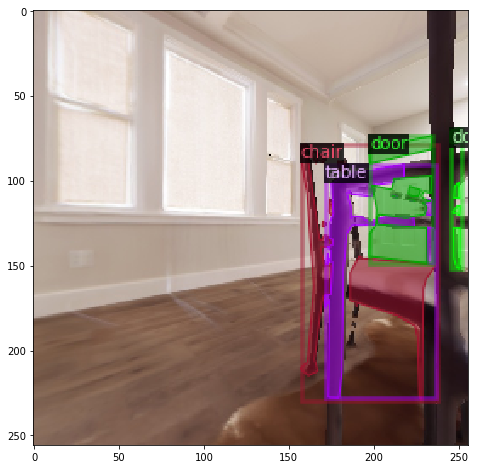

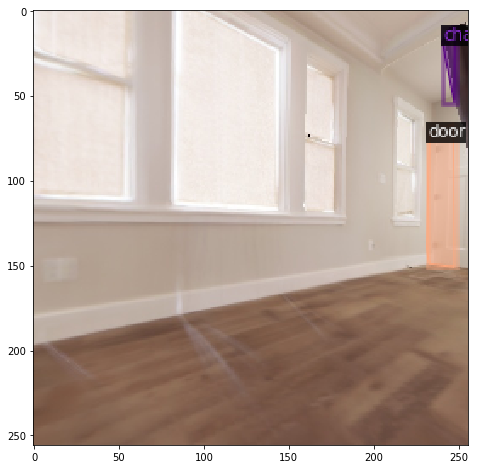

SOLVER PARAMS (500, 100, 0.001)
recreating output/500/default_apt0_gt50p2fix_corln
output/500/default_apt0_gt50p2fix_corln
[06/21 21:41:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/21 21:41:29 d2.engine.train_loop]: Starting training from iteration 0
[06/21 21:41:33 d2.utils.events]:  eta: 0:01:48  iter: 19  total_loss: 3.53  loss_cls: 1.712  loss_box_reg: 0.6468  loss_mask: 0.6913  loss_rpn_cls: 0.1777  loss_rpn_loc: 0.06002  time: 0.2259  data_time: 0.0108  lr: 0.00019081  max_mem: 3522M
[06/21 21:41:38 d2.utils.events]:  eta: 0:01:43  iter: 39  total_loss: 2.518  loss_cls: 0.8074  loss_box_reg: 0.8406  loss_mask: 0.6404  loss_rpn_cls: 0.08182  loss_rpn_loc: 0.1246  time: 0.2268  data_time: 0.0040  lr: 0.00039061  max_mem: 3522M
[06/21 21:41:43 d2.utils.events]:  eta: 0:01:40  iter: 59  total_loss: 2.172  loss_cls: 0.597  loss_box_reg: 0.8293  loss_mask: 0.5265  loss_rpn_cls: 0.07634  loss_rpn_loc: 0.08035  time: 0.2294  data_time: 0.0040  lr: 0.00059041  max_mem: 3522M
[06/21 21:41:47 d2.utils.events]:  eta: 0:01:37  iter: 79  total_loss: 1.986  loss_cls: 0.4801  loss_box_reg: 0.7584  loss_mask: 0.4986  loss_rpn_cls: 0.0707  loss_rpn_loc: 0.178  time: 0.23

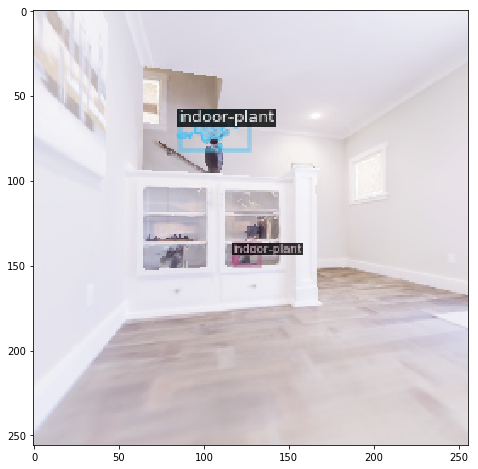

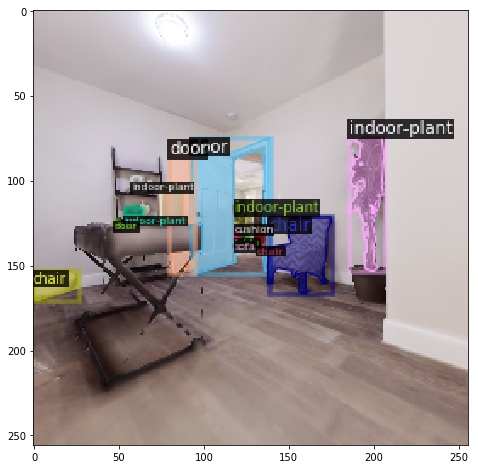

SOLVER PARAMS (500, 100, 0.001)
recreating output/500/default_apt0_gt50p2fix_corln
output/500/default_apt0_gt50p2fix_corln
[06/21 21:45:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[06/21 21:45:08 d2.engine.train_loop]: Starting training from iteration 0
[06/21 21:45:13 d2.utils.events]:  eta: 0:01:49  iter: 19  total_loss: 3.736  loss_cls: 1.826  loss_box_reg: 0.7772  loss_mask: 0.6864  loss_rpn_cls: 0.2987  loss_rpn_loc: 0.0809  time: 0.2285  data_time: 0.0106  lr: 0.00019081  max_mem: 3522M
[06/21 21:45:18 d2.utils.events]:  eta: 0:01:46  iter: 39  total_loss: 2.482  loss_cls: 0.7386  loss_box_reg: 0.7376  loss_mask: 0.6546  loss_rpn_cls: 0.1342  loss_rpn_loc: 0.1904  time: 0.2302  data_time: 0.0039  lr: 0.00039061  max_mem: 3522M
[06/21 21:45:22 d2.utils.events]:  eta: 0:01:43  iter: 59  total_loss: 2.08  loss_cls: 0.5834  loss_box_reg: 0.7938  loss_mask: 0.575  loss_rpn_cls: 0.05683  loss_rpn_loc: 0.08691  time: 0.2327  data_time: 0.0038  lr: 0.00059041  max_mem: 3522M
[06/21 21:45:27 d2.utils.events]:  eta: 0:01:39  iter: 79  total_loss: 1.959  loss_cls: 0.4376  loss_box_reg: 0.7703  loss_mask: 0.472  loss_rpn_cls: 0.05053  loss_rpn_loc: 0.1241  time: 0.233

In [ ]:

maxiters = 500
lr = [0.001, 0.002, 0.005, 0.01, 0.02]
warmup = [100, 200]

def loop(train_json, n):
    results = {
        "bbox": {
            "AP50": []
        },
        "segm": {
            "AP50": []
        }
    }
    for _ in range(n):
        c = COCOTrain(lr[0], warmup[0], maxiters)
        dataset_name = x.split('.')[0][len('active_vision/'):]
        print(f'dataset_name {dataset_name}')
        c.run_train(x, test_json, img_dir_train, img_dir_test, dataset_name)
        for yix in range(len(test_jsons)):
            r = c.run_eval(str(yix), test_jsons[yix], img_dir_test)
        print(f'all results {c.results}')
        results['bbox']['AP50'].append(c.results['bbox']['AP50'])
        results['segm']['AP50'].append(c.results['segm']['AP50'])
        with open("nway_summary_items.txt", "a") as f:
            f.write(f'\ntrain_json {x}')
            f.write(f"\nbbox AP50 {sum(c.results['bbox']['AP50'])/len(c.results['bbox']['AP50'])}")
            f.write(f"\nsegm AP50 {sum(c.results['segm']['AP50'])/len(c.results['segm']['AP50'])}")
            f.write(f'\nall results {c.results}')
    
    from setuptools.namespaces import flatten
    results['bbox']['AP50'] = list(flatten(results['bbox']['AP50']))
    results['segm']['AP50'] = list(flatten(results['segm']['AP50']))
    print(results)
    with open("nway_summary.txt", "a") as f:
        f.write(f'\ntrain_json {train_json}, average over {n} runs')
        f.write(f"\nbbox AP50 {sum(results['bbox']['AP50'])/len(results['bbox']['AP50'])}")
        f.write(f"\nsegm AP50 {sum(results['segm']['AP50'])/len(results['segm']['AP50'])}")
            
for x in train_jsons:
    loop(x, 10)
    